In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
df = generate_training_data(samples=10000)
X = df[['w1', 'Cb']].values
y = df['Cb_next'].values

100%|██████████| 10000/10000 [00:00<00:00, 80955.02it/s]


In [65]:
model = SVR(kernel='rbf', C=10).fit(X, y)

100%|██████████| 60/60 [00:08<00:00,  7.07it/s]


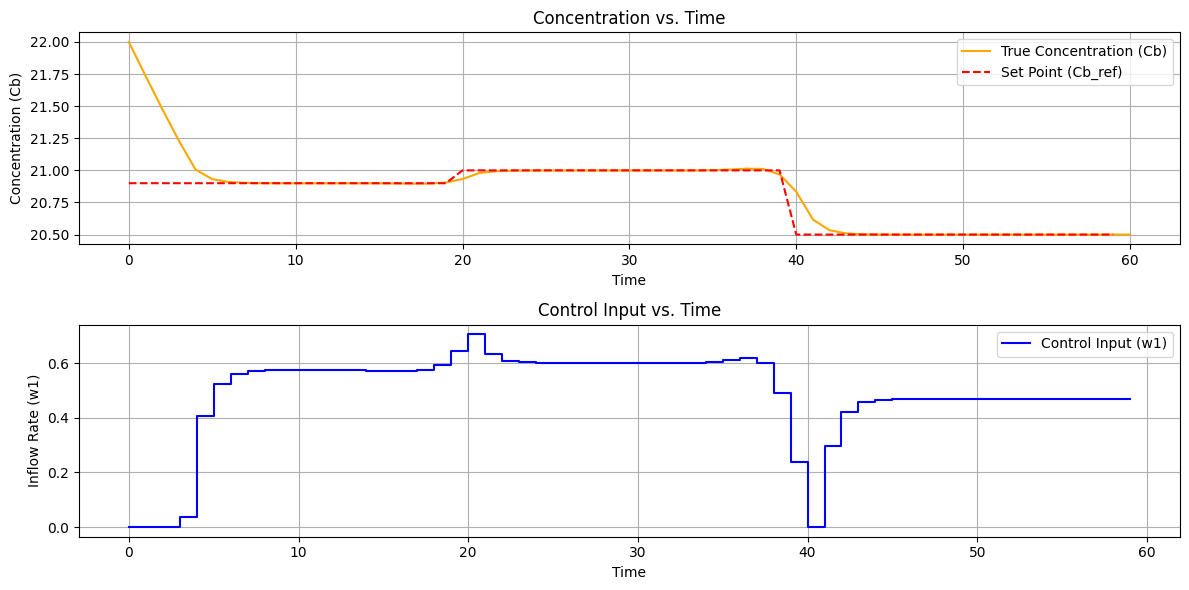

In [66]:
# --- Cost Function ---
def mpc_cost(w1_seq,w1_ini,Cb_ref, Cb0, w2, model, Q, R, N):
    cost = 0
    Cb = Cb0
    for idx in range(N):
        w1 = w1_seq[idx]
        Cb = model_predict(Cb, w1, w2, model)
        cost += Q * (Cb_ref[idx] - Cb) ** 2
        if idx > 0:  # Penalize difference between consecutive control actions
            cost += R * (w1 - w1_seq[idx - 1]) ** 2
    return cost

# --- MPC Solver ---
def solve_mpc(Cb_ref, Cb, w1_ini, w2, model, Q, R, N, w1_min, w1_max, delta_w1_max):
    """
    Solve the MPC optimization problem.
    """
    # Ensure the reference trajectory matches the prediction horizon
    if len(Cb_ref) < N:
        Cb_ref = np.append(Cb_ref, [Cb_ref[-1]] * (N - len(Cb_ref)))  # Pad with the last value

    # Linear constraints on the rate of change of w1
    delta_w1_matrix = np.eye(N) - np.eye(N, k=1)
    rate_constraint = LinearConstraint(delta_w1_matrix, -delta_w1_max, delta_w1_max)

    # Bounds on the control input
    bounds = [(w1_min, w1_max) for _ in range(N)]

    # Solve the optimization problem
    result = minimize(
        mpc_cost,
        w1_ini,
        args=(w1_ini, Cb_ref, Cb, w2, model, Q, R, N),
        bounds=bounds,
        constraints=[rate_constraint],
    )

    # Handle optimization failures
    if not result.success:
        print("Optimization failed, using default control inputs")
        return np.ones(N) * w1_min

    return result.x

# --- Simulation Setup ---
Cb = np.zeros(L + 1)
Cb[0] = Cb0
w1 = np.zeros(L)
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])
w1_ini = np.ones(N) * 2.0

for idx in tqdm(range(L)):
    # Adjust the reference trajectory slice for the prediction horizon
    Cb_ref_slice = Cb_ref[idx:idx+N]
    if len(Cb_ref_slice) < N:
        Cb_ref_slice = np.append(Cb_ref_slice, [Cb_ref_slice[-1]] * (N - len(Cb_ref_slice)))

    # Solve the MPC optimization problem
    w1_mpc = solve_mpc(
        Cb_ref_slice, Cb[idx], w1_ini, w2, model, Q, R, N, w1_min, w1_max, delta_w1_max
    )

    # Apply the first control input
    w1[idx] = w1_mpc[0]
    w1_ini = np.append(w1_mpc[1:], w1_mpc[-1])  # Shift control sequence

    # Update system state using NN
    Cb[idx+1]=model_predict(Cb[idx],w1[idx],w2,model)

# --- Plot Results ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(range(L + 1), Cb, label="True Concentration (Cb)", color="orange")
plt.plot(range(L), Cb_ref, label="Set Point (Cb_ref)", linestyle="--", color="red")
plt.xlabel("Time")
plt.ylabel("Concentration (Cb)")
plt.title("Concentration vs. Time")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.step(range(L), w1, where="post", label="Control Input (w1)", color="blue")
plt.xlabel("Time")
plt.ylabel("Inflow Rate (w1)")
plt.title("Control Input vs. Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()